In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [2]:
tf.compat.v1.enable_v2_behavior()

In [3]:
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [4]:
tf.version.VERSION

'2.1.0'

In [5]:
num_iterations = 20000 # @param {type: "integer"}

initial_collect_steps = 1000 # @param {type: "integer"}
collect_steps_per_iteration = 1
replay_buffer_max_length = 100000

batch_size = 64
learning_rate = 1e-3
log_interval = 200

num_eval_episodes = 10
eval_interval = 1000

In [6]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

In [7]:
env

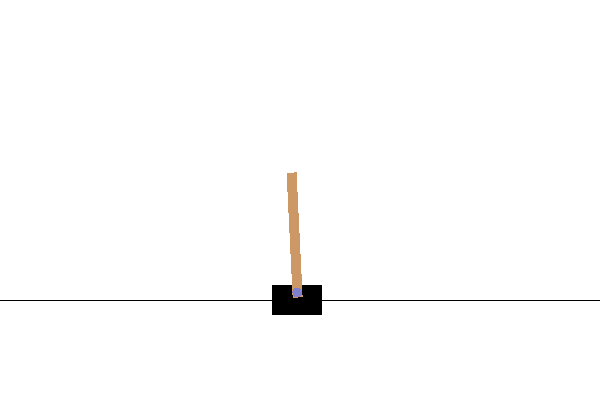

In [8]:
env.reset()
PIL.Image.fromarray(env.render())

In [14]:
print(env._batch_size)

AttributeError: 'CartPoleEnv' object has no attribute '_batch_size'

In [17]:
env.action_spec()

BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)

In [9]:
env.render(mode="rgb_array")

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [20]:
env.batched

False

In [18]:
env.step(np.array([env.action_space.sample()]))

TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.04074619, -0.17248163, -0.04771055,  0.27610734], dtype=float32))

In [15]:
env.action_space.sample()

1

In [16]:
?env.step

In [21]:
print('Observation spec:')
print(env.time_step_spec().observation)

Observation spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [22]:
print("Reward spec:")
print(env.time_step_spec().reward)

Reward spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [23]:
print('Action spec:')
print(env.action_spec())

Action spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In [24]:
time_step = env.reset()
print('Time step:')
print(time_step)

Time step:
TimeStep(step_type=array(0, dtype=int32), reward=array(0., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.04094087, -0.00812779, -0.0492896 , -0.02680687], dtype=float32))


In [25]:
action = np.array(1, dtype=np.int32)

In [26]:
next_time_step = env.step(action)

In [27]:
print('Next time step:')
print(next_time_step)

Next time step:
TimeStep(step_type=array(1, dtype=int32), reward=array(1., dtype=float32), discount=array(1., dtype=float32), observation=array([-0.04110342,  0.18766509, -0.04982574, -0.3346248 ], dtype=float32))


In [28]:
train_py_env = suite_gym.load(env_name)
test_py_env  = suite_gym.load(env_name)

In [29]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env  = tf_py_environment.TFPyEnvironment(train_py_env)

In [30]:
fc_layer_params = (100,)

In [31]:
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params
)

In [33]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()

In [34]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

In [35]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                               train_env.action_spec())

In [36]:
example_environment = tf_py_environment.TFPyEnvironment(suite_gym.load(env_name))

In [37]:
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

In [38]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0
    
    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0
        
        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward
        
        total_return += episode_return
        
    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [41]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

18.1

In [42]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length
)

In [43]:
agent.collect_data_spec

Trajectory(step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), observation=BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)), action=BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)), policy_info=(), next_step_type=TensorSpec(shape=(), dtype=tf.int32, name='step_type'), reward=TensorSpec(shape=(), dtype=tf.float32, name='reward'), discount=BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)))

In [44]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

In [48]:
def collect_step(environment, policy, buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)
    next_time_step = environment.step(action_step.action)
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    
    buffer.add_batch(traj)
    
def collect_data(env, policy, buffer, steps):
    for _ in range(steps):
        collect_step(env, policy, buffer)

In [52]:
iter(replay_buffer.as_dataset()).next()

InvalidArgumentError: assertion failed: [TFUniformReplayBuffer is empty. Make sure to add items before sampling the buffer.] [Condition x > y did not hold element-wise:] [x (TFUniformReplayBuffer/get_next/SelectV2_1:0) = ] [0] [y (TFUniformReplayBuffer/get_next/SelectV2:0) = ] [0]
	 [[{{node TFUniformReplayBuffer/get_next/assert_greater/Assert/AssertGuard/else/_1/Assert}}]]

In [57]:
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2
).prefetch(3)

In [58]:
iterator = iter(dataset)
print(iterator)

In [63]:
iterator.next()

InvalidArgumentError: assertion failed: [TFUniformReplayBuffer is empty. Make sure to add items before sampling the buffer.] [Condition x > y did not hold element-wise:] [x (TFUniformReplayBuffer/get_next/SelectV2_1:0) = ] [0] [y (TFUniformReplayBuffer/get_next/SelectV2:0) = ] [0]
	 [[{{node TFUniformReplayBuffer/get_next/assert_greater/Assert/AssertGuard/else/_1/Assert}}]]

In [65]:
# Optimize the graph
agent.train = common.function(agent.train)

# Reset the iteration counter
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):
    for _ in range(collect_steps_per_iteration):
        collect_step(train_env, agent.collect_policy, replay_buffer)
    experience, unused_info = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    
    if step % log_interval == 0:
        print('Step {0}: loss = {1}'.format(step, train_loss))
    
    if step % eval_interval == 0:
        avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
        print('step {0}: average return = {1}'.format(step, avg_return))
        returns.append(avg_return)

InvalidArgumentError: assertion failed: [TFUniformReplayBuffer is empty. Make sure to add items before sampling the buffer.] [Condition x > y did not hold element-wise:] [x (TFUniformReplayBuffer/get_next/SelectV2_1:0) = ] [0] [y (TFUniformReplayBuffer/get_next/SelectV2:0) = ] [0]
	 [[{{node TFUniformReplayBuffer/get_next/assert_greater/Assert/AssertGuard/else/_1/Assert}}]]

In [67]:
collect_step(train_env, agent.collect_policy, replay_buffer)

In [68]:
dir(replay_buffer

In [21]:
num_episodes = tf_metrics.NumberOfEpisodes()
env_steps = tf_metrics.EnvironmentSteps()
observers = [num_episodes, env_steps]
driver = dynamic_episode_driver.DynamicEpisodeDriver(
    tf_env, tf_policy, observers, num_episodes=2)

# Initial driver.run will reset the environment and initialize the policy.
final_time_step, policy_state = driver.run()

print('final_time_step', final_time_step)
print('Number of Steps: ', env_steps.result().numpy())
print('Number of Episodes: ', num_episodes.result().numpy())


NameError: name 'dynamic_episode_driver' is not defined